**Задание**

***Распознавание рукописного ввода на примере базы MNIST***

Построить классификатор изображений рукописного ввода на базе MNIST.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

**Digit Recognizer**

In [2]:
%matplotlib inline
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Загружаем исходные данные

In [ ]:
train = np.loadtxt('/content/drive/MyDrive/Компьютерное зрение/Сегментация и детекция объектов/Данные для ДЗ/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('/content/drive/MyDrive/Компьютерное зрение/Сегментация и детекция объектов/Данные для ДЗ/test.csv', delimiter=',', skiprows=1)

In [ ]:
train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [7., 0., 0., ..., 0., 0., 0.],
       [6., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.]])

In [ ]:
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [ ]:
train_img.shape

(42000, 28, 28)

**Визуализируем исходные данные**

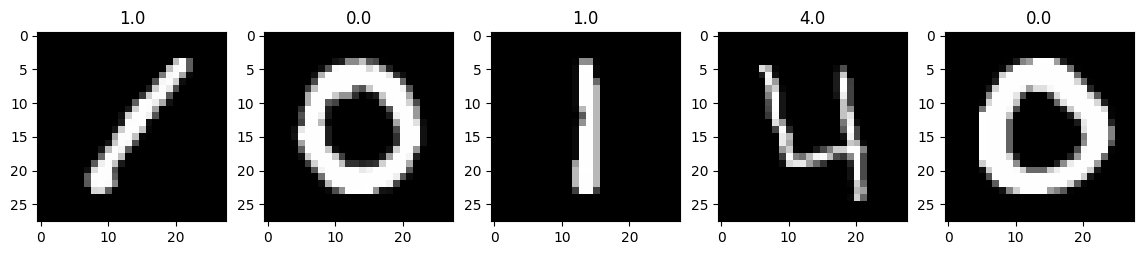

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

**Вычисляем X и Y составляющие градиента с помощью оператора Собеля**

In [ ]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [ ]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

**Вычисляем угол и длину вектора градиента**

In [ ]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [ ]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

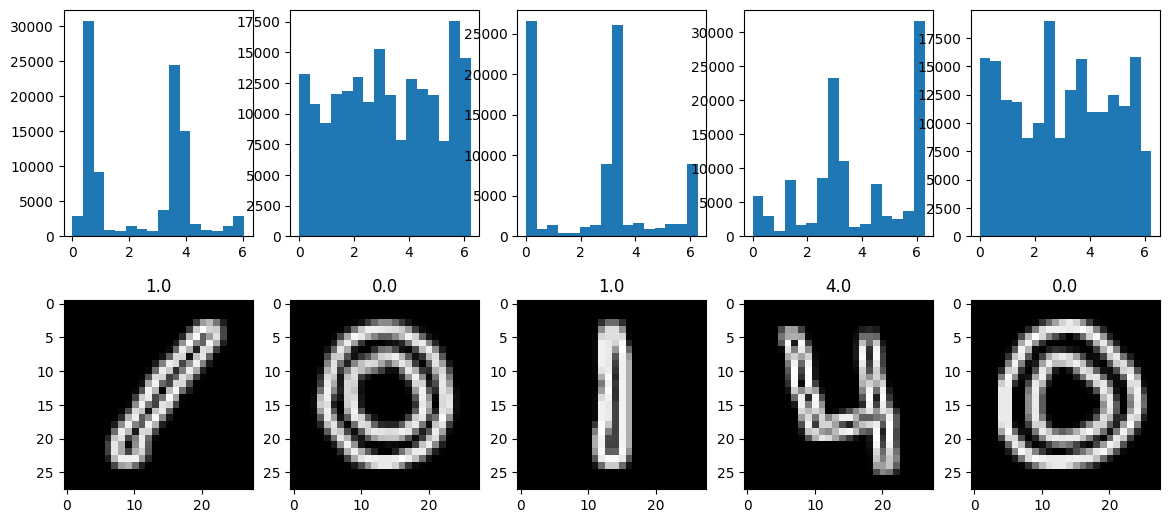

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

**Вычисляем гистограммы градиентов**

In [ ]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [ ]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

**Нормируем вектор гистограммы**

In [ ]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [ ]:
train_hist.shape

(42000, 16)

In [ ]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

In [ ]:
test_hist.shape

(28000, 16)

**Разбиваем выборку на обучение и валидацию**

In [ ]:
from sklearn.model_selection import train_test_split
y_train, y_test, X_train, X_test = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

Рассмотрим несколько вариантов модели классификатора и выберем модель с наилучшими показателями

***LogisticRegression***

In [ ]:
# импортируем LR-функционал
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [ ]:
# обучаем модель

model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred = model.predict(X_test) # тестируем получившуюся модель (передаем значение X и выводим значение y, которые предсказала модель на этих X)
y_pred

array([6., 1., 4., ..., 3., 5., 9.])

In [ ]:
y_test # реальные ответы X, которые были собраны при реальных наблюдениях

array([8., 1., 9., ..., 3., 0., 9.])

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_test, y_pred))

Accuracy: 0.5770238095238095


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.36      0.27      0.31       816
         1.0       0.91      0.96      0.93       909
         2.0       0.41      0.30      0.35       846
         3.0       0.59      0.69      0.64       937
         4.0       0.62      0.60      0.61       839
         5.0       0.54      0.63      0.58       702
         6.0       0.40      0.41      0.41       785
         7.0       0.79      0.78      0.78       893
         8.0       0.44      0.53      0.48       835
         9.0       0.57      0.54      0.55       838

    accuracy                           0.58      8400
   macro avg       0.56      0.57      0.56      8400
weighted avg       0.57      0.58      0.57      8400



In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[221  10  71  32  50  26 164   4 188  50]
 [  1 876   3   0  18   0   3   2   1   5]
 [ 48   0 256 175  14 166  42  30 101  14]
 [ 23   0  73 645   1 102   7   7  66  13]
 [ 16  54  10   5 506   0 103  44  17  84]
 [  7   0  80 119   0 439   9   9  35   4]
 [115   6  57  18  88  10 319  15  92  65]
 [  6  13  26   7  40  15  34 693  10  49]
 [126   0  34  63  12  47  45   8 441  59]
 [ 43   6  22  28  93   8  62  70  55 451]]


Используем RandomizedSearchCV для поиска оптимальных гиперпараметров

In [ ]:
from scipy.stats import randint

In [ ]:
# скроем вывод предупреждений
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Определение диапазонов значений для случайного поиска
param_dist = {
    'max_iter': randint(50, 1000),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['elasticnet', 'l1', 'l2', None],
    'C': randint(1, 100)
}

In [ ]:
# Создание модели и настройка с использованием случайного поиска
model = LogisticRegression()
random_search = RandomizedSearchCV(model, param_distributions = param_dist, n_iter=100, cv=5)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b840c205110>,
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b840c172cd0>,
                                        'penalty': ['elasticnet', 'l1', 'l2',
                                                    None],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']})

In [ ]:
# Вывод наилучших гиперпараметров и оценки
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

Best Hyperparameters: {'C': 53, 'max_iter': 291, 'penalty': None, 'solver': 'saga'}
Best Cross-Validation Score: 0.5868154761904762


Подставим найденные наилучшие гиперпараметры при использовании RandomizedSearchCV в модель логистической регрессии и посмотрим на метрики качества

In [ ]:
lg_model_rand = LogisticRegression(C = 53, max_iter = 291, penalty = None, solver ='saga')
lg_model_rand.fit(X_train, y_train)

LogisticRegression(C=53, max_iter=291, penalty=None, solver='saga')

In [ ]:
y_pred = lg_model_rand.predict(X_test) # тестируем получившуюся модель (передаем значение X и выводим значение y, которые предсказала модель на этих X)
y_pred

array([9., 1., 9., ..., 3., 5., 9.])

In [ ]:
y_test # реальные ответы X, которые были собраны при реальных наблюдениях

array([8., 1., 9., ..., 3., 0., 9.])

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_test, y_pred))

Accuracy: 0.5817857142857142


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.38      0.28      0.32       816
         1.0       0.92      0.95      0.93       909
         2.0       0.42      0.32      0.36       846
         3.0       0.60      0.69      0.64       937
         4.0       0.62      0.62      0.62       839
         5.0       0.54      0.63      0.58       702
         6.0       0.40      0.40      0.40       785
         7.0       0.79      0.78      0.79       893
         8.0       0.44      0.54      0.49       835
         9.0       0.57      0.54      0.56       838

    accuracy                           0.58      8400
   macro avg       0.57      0.58      0.57      8400
weighted avg       0.57      0.58      0.58      8400



При использовании RandomizedSearchCV для поиска оптимальных гиперпараметров метрика accuracy улучшилась незначительно с 0,577 до 0,582.

***tree.DecisionTreeClassifier***

In [ ]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn. metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

CPU times: user 248 ms, sys: 26.1 ms, total: 274 ms
Wall time: 393 ms


Обучим дерево решений на обучающем множестве

In [ ]:
clf = DecisionTreeClassifier(random_state=42)

In [ ]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
y_pred_ = clf.predict(X_test) # тестируем получившуюся модель (передаем значение X и выводим значение y, которые предсказала модель на этих X)
y_pred_

array([6., 1., 9., ..., 3., 2., 8.])

In [ ]:
y_test # реальные ответы X, которые были собраны при реальных наблюдениях

array([8., 1., 9., ..., 3., 0., 9.])

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_test, y_pred_))

Accuracy: 0.48964285714285716


In [ ]:
print(classification_report(y_test, y_pred_))

              precision    recall  f1-score   support

         0.0       0.30      0.29      0.29       816
         1.0       0.93      0.92      0.93       909
         2.0       0.30      0.31      0.31       846
         3.0       0.50      0.50      0.50       937
         4.0       0.55      0.54      0.54       839
         5.0       0.47      0.48      0.48       702
         6.0       0.30      0.31      0.30       785
         7.0       0.67      0.66      0.66       893
         8.0       0.36      0.36      0.36       835
         9.0       0.47      0.46      0.47       838

    accuracy                           0.49      8400
   macro avg       0.48      0.48      0.48      8400
weighted avg       0.49      0.49      0.49      8400



In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred_))

[[237  12  84  45  42  23 139  25 153  56]
 [  4 837   1   1  24   0   6  20   4  12]
 [ 73   0 262 146  16 117  82  37  84  29]
 [ 35   2 144 467   4 135  30  12  87  21]
 [ 48  22  18   8 454   3  90  74  21 101]
 [ 26   0 119 135   3 339  15  15  41   9]
 [138   6  60  26  87  27 240  32  86  83]
 [ 20  15  42   6  94  16  32 586  14  68]
 [148   0  88  83  12  50  78  15 303  58]
 [ 64   6  48  21  92  14  98  65  42 388]]


Используем RandomizedSearchCV для поиска оптимальных гиперпараметров

In [ ]:
# Определение диапазонов значений для случайного поиска
param_dist = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': randint(1, 50),
    'min_samples_split': randint(1, 10),
    'min_samples_leaf': randint(1, 10)
}

In [ ]:
# Создание модели и настройка с использованием случайного поиска
DTC_model = DecisionTreeClassifier(random_state=42)
random_search = RandomizedSearchCV(DTC_model, param_distributions = param_dist, n_iter=100, cv=5)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b840c21a310>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b840c23c710>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b840c9e4910>})

In [ ]:
# Вывод наилучших гиперпараметров и оценки
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 9}
Best Cross-Validation Score: 0.5300595238095238


Подставим найденные наилучшие гиперпараметры при использовании RandomizedSearchCV в метод решающих деревьев (DecisionTreeClassifier) и посмотрим на метрики качества

In [ ]:
DTC_model_rand = DecisionTreeClassifier(criterion = 'gini', max_depth = 13, min_samples_split = 9, min_samples_leaf = 1)
DTC_model_rand.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=13, min_samples_split=9)

In [ ]:
y_pred_ = DTC_model_rand.predict(X_test) # тестируем получившуюся модель (передаем значение X и выводим значение y, которые предсказала модель на этих X)
y_pred_

array([6., 1., 9., ..., 3., 5., 8.])

In [ ]:
y_test # реальные ответы X, которые были собраны при реальных наблюдениях

array([8., 1., 9., ..., 3., 0., 9.])

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_test, y_pred_))

Accuracy: 0.5303571428571429


In [ ]:
print(classification_report(y_test, y_pred_))

              precision    recall  f1-score   support

         0.0       0.29      0.30      0.29       816
         1.0       0.94      0.92      0.93       909
         2.0       0.36      0.31      0.34       846
         3.0       0.54      0.57      0.56       937
         4.0       0.59      0.57      0.58       839
         5.0       0.52      0.54      0.53       702
         6.0       0.34      0.37      0.36       785
         7.0       0.74      0.66      0.70       893
         8.0       0.41      0.49      0.44       835
         9.0       0.55      0.51      0.53       838

    accuracy                           0.53      8400
   macro avg       0.53      0.52      0.53      8400
weighted avg       0.54      0.53      0.53      8400



Применение RandomizedSearchCV для поиска оптимальных гиперпараметров незначительно улучшило метрику accuracy с 0,49 до 0,53.

***ensemble.RandomForestClassifier***

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

CPU times: user 37 µs, sys: 4 µs, total: 41 µs
Wall time: 52 µs


In [ ]:
# Создаем модель RandomForest
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred_test = clf_rf.predict(X_test) # тестируем получившуюся модель (передаем значение X и выводим значение y, которые предсказала модель на этих X)
y_pred_test

array([6., 1., 9., ..., 5., 2., 9.])

In [ ]:
y_test # реальные ответы X, которые были собраны при реальных наблюдениях

array([8., 1., 9., ..., 3., 0., 9.])

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_test, y_pred_test))

Accuracy: 0.6419047619047619


In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.42      0.40      0.41       816
         1.0       0.97      0.96      0.97       909
         2.0       0.50      0.46      0.48       846
         3.0       0.64      0.68      0.66       937
         4.0       0.71      0.70      0.71       839
         5.0       0.62      0.67      0.64       702
         6.0       0.47      0.45      0.46       785
         7.0       0.86      0.80      0.83       893
         8.0       0.51      0.56      0.53       835
         9.0       0.66      0.68      0.67       838

    accuracy                           0.64      8400
   macro avg       0.64      0.64      0.64      8400
weighted avg       0.64      0.64      0.64      8400



Используем RandomizedSearchCV для поиска оптимальных гиперпараметров

In [ ]:
# Определение диапазонов значений для случайного поиска
param_dist = {
    'n_estimators': [30, 40, 50, 60, 70, 80, 100],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
# Создаем модель RandomForest
clf_rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(clf_rf, param_distributions = param_dist, n_iter=72, cv=5)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=72,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40, 50],
                                        'min_samples_leaf': [1, 2, 4],
                                        'n_estimators': [30, 40, 50, 60, 70, 80,
                                                         100]})

In [ ]:
# Вывод наилучших гиперпараметров и оценки
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

Best Hyperparameters: {'n_estimators': 100, 'min_samples_leaf': 1, 'max_depth': 40}
Best Cross-Validation Score: 0.6416666666666668


Подставим найденные наилучшие гиперпараметры при использовании RandomizedSearchCV в модель Случайного леса (Random Forest)

In [ ]:
# Обучение модель случайного леса

rf_model_rand = RandomForestClassifier(random_state=42, max_depth=40, min_samples_leaf=1, n_estimators = 100)
rf_model_rand.fit(X_train, y_train)
# prediction = rf_model_rand.predict(X_test)

RandomForestClassifier(max_depth=40, random_state=42)

In [ ]:
y_pred = rf_model_rand.predict(X_test) # тестируем получившуюся модель (передаем значение X и выводим значение y, которые предсказала модель на этих X)
y_pred

array([6., 1., 9., ..., 5., 2., 9.])

In [ ]:
y_test # реальные ответы X, которые были собраны при реальных наблюдениях

array([8., 1., 9., ..., 3., 0., 9.])

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_test, y_pred))

Accuracy: 0.6417857142857143


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.42      0.40      0.41       816
         1.0       0.97      0.96      0.97       909
         2.0       0.50      0.46      0.48       846
         3.0       0.65      0.68      0.66       937
         4.0       0.71      0.70      0.71       839
         5.0       0.62      0.67      0.64       702
         6.0       0.46      0.45      0.46       785
         7.0       0.86      0.80      0.83       893
         8.0       0.50      0.56      0.53       835
         9.0       0.66      0.68      0.67       838

    accuracy                           0.64      8400
   macro avg       0.64      0.64      0.64      8400
weighted avg       0.64      0.64      0.64      8400



In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[323   7  61  28  29  19 132  13 167  37]
 [  3 873   2   0  21   0   1   5   0   4]
 [ 57   0 388 130   4 109  53  14  74  17]
 [ 22   0  91 640   1  90   7   5  73   8]
 [ 18  13  13   3 589   1  85  30   9  78]
 [ 11   0  74 102   0 471   6   5  29   4]
 [140   1  55  10  65  11 354  12  77  60]
 [  6   3  29   6  43  13  24 710   6  53]
 [140   0  36  57  13  40  40   6 471  32]
 [ 44   1  25  15  59   7  60  27  28 572]]


Применение RandomizedSearchCV для поиска оптимальных гиперпараметров на величину метрики accuracy не повлияло.



***Бэггинг модели tree.DecisionTreeClassifier***

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
clf = DecisionTreeClassifier(random_state=42)

In [ ]:
bagging = BaggingClassifier(clf,
                           n_estimators=150,
                           max_samples=0.5,
                           max_features=0.5,
                           random_state=42)

In [ ]:
bagging.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.5, max_samples=0.5, n_estimators=150,
                  random_state=42)

In [ ]:
y_pred_test_bag = bagging.predict(X_test) # тестируем получившуюся модель (передаем значение X и выводим значение y, которые предсказала модель на этих X)
y_pred_test_bag

array([6., 1., 9., ..., 5., 5., 9.])

In [ ]:
y_test # реальные ответы X, которые были собраны при реальных наблюдениях

array([8., 1., 9., ..., 3., 0., 9.])

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_test, y_pred_test_bag))

Accuracy: 0.6359523809523809


In [ ]:
print(classification_report(y_test, y_pred_test_bag))

              precision    recall  f1-score   support

         0.0       0.41      0.36      0.38       816
         1.0       0.97      0.96      0.97       909
         2.0       0.48      0.44      0.46       846
         3.0       0.63      0.68      0.65       937
         4.0       0.71      0.71      0.71       839
         5.0       0.61      0.66      0.63       702
         6.0       0.48      0.44      0.46       785
         7.0       0.84      0.81      0.82       893
         8.0       0.49      0.58      0.53       835
         9.0       0.66      0.67      0.66       838

    accuracy                           0.64      8400
   macro avg       0.63      0.63      0.63      8400
weighted avg       0.63      0.64      0.63      8400



In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred_test_bag))

[[291   5  68  36  35  17 129  12 180  43]
 [  0 874   2   0  22   0   2   5   0   4]
 [ 66   0 369 139   2 115  44  16  80  15]
 [ 17   0  93 634   0  94   8   3  81   7]
 [ 19  14  10   2 598   2  72  38   7  77]
 [  4   0  69 114   0 463   6   7  36   3]
 [133   1  58   9  71   6 349  16  77  65]
 [  3   3  32   5  46  16  17 720   5  46]
 [122   0  36  56  12  44  45   5 484  31]
 [ 49   1  26  16  59   5  60  33  29 560]]


Используем RandomizedSearchCV для поиска оптимальных гиперпараметров

In [ ]:
# Определение диапазонов значений для случайного поиска
param_dist = {
    'n_estimators': randint(1, 200),
    'max_samples': randint(1, 20),
    'max_features': randint(1, 30)
}

In [ ]:
DTC_model = DecisionTreeClassifier(random_state=42)

In [ ]:
# Создание модели и настройка с использованием случайного поиска
Bag_model = BaggingClassifier(DTC_model, random_state=42)
random_search = RandomizedSearchCV(Bag_model, param_distributions = param_dist, n_iter=100, cv=5)
random_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
255 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
255 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^

RandomizedSearchCV(cv=5,
                   estimator=BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                                               random_state=42),
                   n_iter=100,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ec5e877a310>,
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ec5e8778890>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ec5e87790d0>})

In [ ]:
# Вывод наилучших гиперпараметров и оценки
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

Best Hyperparameters: {'max_features': 11, 'max_samples': 17, 'n_estimators': 170}
Best Cross-Validation Score: 0.4923809523809524


Подставим найденные наилучшие гиперпараметры при использовании RandomizedSearchCV в модель Бэггинга и посмотрим на метрики качества

In [ ]:
Bag_model_rand = BaggingClassifier(DTC_model, random_state=42, n_estimators = 170, max_samples = 17, max_features = 11)
Bag_model_rand.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                  max_features=11, max_samples=17, n_estimators=170,
                  random_state=42)

In [ ]:
y_pred = Bag_model_rand.predict(X_test) # тестируем получившуюся модель (передаем значение X и выводим значение y, которые предсказала модель на этих X)
y_pred

array([8., 1., 4., ..., 3., 3., 9.])

In [ ]:
y_test # реальные ответы X, которые были собраны при реальных наблюдениях

array([8., 1., 9., ..., 3., 0., 9.])

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_test, y_pred))

Accuracy: 0.4911904761904762


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.29      0.25      0.27       816
         1.0       0.78      0.98      0.87       909
         2.0       0.34      0.22      0.27       846
         3.0       0.45      0.66      0.54       937
         4.0       0.48      0.60      0.53       839
         5.0       0.52      0.42      0.47       702
         6.0       0.33      0.39      0.36       785
         7.0       0.85      0.49      0.63       893
         8.0       0.39      0.51      0.44       835
         9.0       0.54      0.30      0.38       838

    accuracy                           0.49      8400
   macro avg       0.50      0.48      0.48      8400
weighted avg       0.50      0.49      0.48      8400



***Стекинг трех моделей: tree.DecisionTreeClassifier, ensemble.RandomForestClassifier, svm.LinearSVC***

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC

In [ ]:
# Создаем стэккинг и обучаем его на данных
clf = DecisionTreeClassifier(random_state=42)
clf_rf = RandomForestClassifier(random_state=42)
Classifier = StackingClassifier(
    [
        ('DecisionTreeClassifier', clf),
        ('RandomForestClassifier', clf_rf),
        ('LinearSVC', LinearSVC(random_state=42))
    ], clf_rf)

In [ ]:
%%time
Classifier.fit(X_train, y_train)

CPU times: user 2min 49s, sys: 1.66 s, total: 2min 50s
Wall time: 2min 51s


StackingClassifier(estimators=[('DecisionTreeClassifier',
                                DecisionTreeClassifier(random_state=42)),
                               ('RandomForestClassifier',
                                RandomForestClassifier(random_state=42)),
                               ('LinearSVC', LinearSVC(random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=42))

In [ ]:
y_pred_stacking = Classifier.predict(X_test) # тестируем получившуюся модель (передаем значение X и выводим значение y, которые предсказала модель на этих X)
y_pred_stacking

array([8., 1., 9., ..., 5., 2., 9.])

In [ ]:
y_test

array([8., 1., 9., ..., 3., 0., 9.])

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_test, y_pred_stacking))

Accuracy: 0.650952380952381


In [ ]:
print(classification_report(y_test, y_pred_stacking))

              precision    recall  f1-score   support

         0.0       0.43      0.40      0.41       816
         1.0       0.97      0.96      0.97       909
         2.0       0.50      0.48      0.49       846
         3.0       0.67      0.69      0.68       937
         4.0       0.73      0.72      0.73       839
         5.0       0.62      0.66      0.64       702
         6.0       0.48      0.46      0.47       785
         7.0       0.88      0.82      0.85       893
         8.0       0.49      0.56      0.52       835
         9.0       0.69      0.69      0.69       838

    accuracy                           0.65      8400
   macro avg       0.65      0.65      0.65      8400
weighted avg       0.65      0.65      0.65      8400



In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred_stacking))

[[325   6  70  28  19  19 128  10 179  32]
 [  3 871   2   0  22   0   2   5   0   4]
 [ 53   0 410 116   5 102  50  14  82  14]
 [ 23   0  98 649   0  83   7   3  65   9]
 [ 28  13  11   3 606   1  85  21   7  64]
 [  7   0  85  93   0 464   8   6  33   6]
 [137   1  57  12  73  12 361  10  74  48]
 [  5   3  25   4  35  12  17 735   6  51]
 [140   0  40  58   9  45  39   6 468  30]
 [ 42   1  21  11  57   8  58  24  37 579]]


Лучшие результаты показала модель Стекинга трех моделей: tree.DecisionTreeClassifier, ensemble.RandomForestClassifier, svm.LinearSVC

In [3]:
accuracy = {
    'Модель' : ['Логистическая регрессия без оптимизации', 'Логистическая регрессия с оптимизацией RandomizedSearchCV', 'Случайный лес без оптимизации', 'Случайный лес с оптимизацией', 'Решающие деревья без оптимизации', 'Решающие деревья с оптимизацией', 'Модель Бэггинга без оптимизации', 'Модель Бэггинга с оптимизацией', 'Модель Стэкинга'],
    'accuracy' : [0.577, 0.582, 0.642, 0.642, 0.489, 0.530, 0.636, 0.492, 0.651]
}
df = pd.DataFrame(accuracy)
df

,Модель,accuracy
0,Логистическая регрессия без оптимизации,0.577
1,Логистическая регрессия с оптимизацией Randomi...,0.582
2,Случайный лес без оптимизации,0.642
3,Случайный лес с оптимизацией,0.642
4,Решающие деревья без оптимизации,0.489
5,Решающие деревья с оптимизацией,0.530
6,Модель Бэггинга без оптимизации,0.636
7,Модель Бэггинга с оптимизацией,0.492
8,Модель Стэкинга,0.651


Предсказания на тестовых данных на модели стекинга

In [ ]:
pred_test = Classifier.predict(test_hist)

Визуализируем предсказания

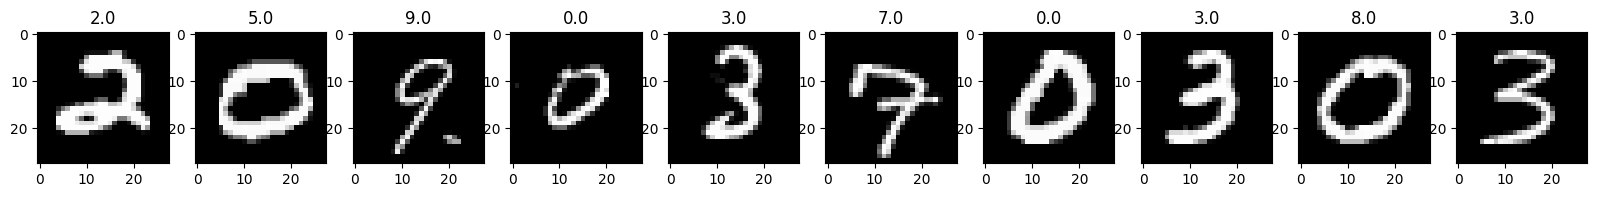

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:10], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

Готовим файл для отправки

In [ ]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [ ]:
!head submit.txt

ImageId,Label
1,2
2,5
3,9
4,0
5,3
6,7
7,0
8,3
9,8


***Скриншот с финальным результатом на Kaggle***

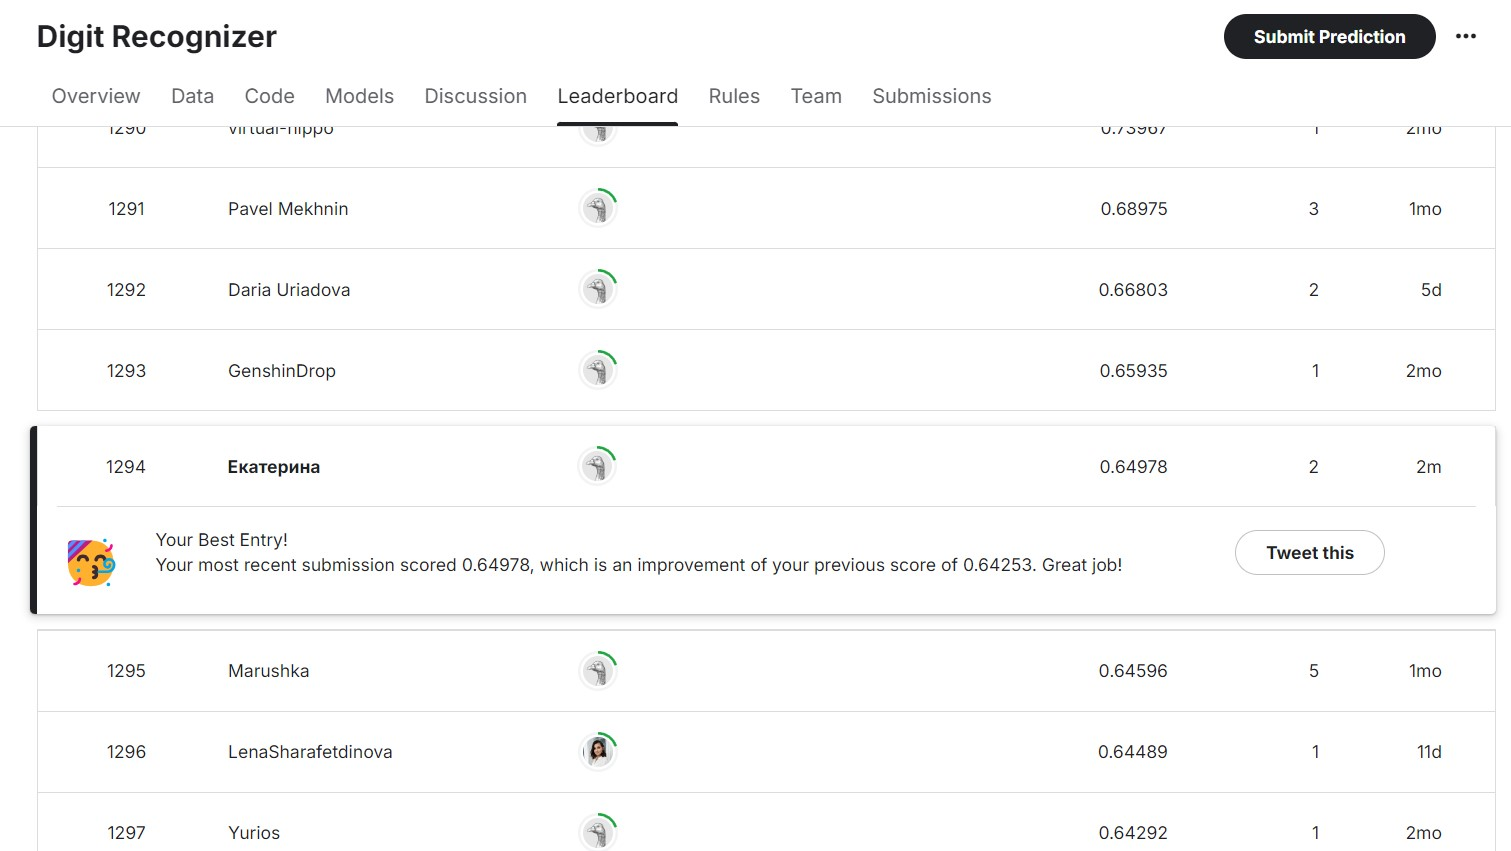

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/Компьютерное зрение/Сегментация и детекция объектов/Данные для ДЗ/Результат распознавания цифр.jpg')